# Subpopulation Prediction

This notebook explores both descriptive analysis and predictive analysis of relationship estimations across subpopulations of age. The goal is to illustrate how predictions and communication patterns vary widely across different populations.

In [1]:
%matplotlib inline
import pickle
import csv
import os, sys, inspect

import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, KFold
import shap

# Stat imports
from scipy.stats import pointbiserialr

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
 # TODO is this line still needed?
lmtest = importr('lmtest')
# https://stackoverflow.com/questions/32983365/rpy2-cannot-find-installed-external-r-packages
Hmisc = importr("Hmisc")
pandas2ri.activate()

import statsmodels.api as sm
import seaborn as sns
lowess = sm.nonparametric.lowess

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *
from model.stats_util import *

In [2]:
predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 1,
        "family_live_together": 3,
        "sig_other": 3
    }
}

replace_dict_6clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}


contact_types_6clf = list(replace_dict_6clf['contact_type'].keys())
contact_types_4clf = ["work", "social", "task", "family_together"]

## Descriptive Statistics

### Top 5 contacts

In [3]:
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

top5_all_data = pd.concat([top5_all_sb_train_data, top5_all_sb_test_data], axis=0)
top5_all_features = top5_all_data.replace(replace_dict_6clf)

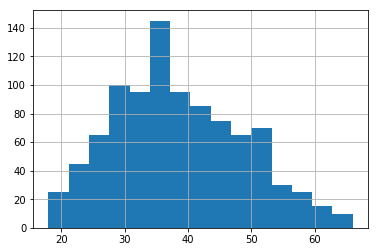

In [4]:
top5_all_data['ego_age'].hist(bins=15)

In [5]:
quartiles = top5_all_data['ego_age'].quantile([0.25, 0.5, 0.75, 1])
terciles = top5_all_data['ego_age'].quantile([0.33, 0.67, 1])

print(quartiles)
print(terciles)

0.25    31.0
0.50    37.0
0.75    46.0
1.00    66.0
Name: ego_age, dtype: float64
0.33    33.0
0.67    43.0
1.00    66.0
Name: ego_age, dtype: float64


In [6]:
age_qlabels = ["age_q" + str(x) for x in range(1,5)]

top5_all_data['ego_age_q'], bins = pd.qcut(top5_all_data['ego_age'], q=4, labels=age_qlabels, retbins=True)

print(top5_all_data['ego_age_q'].value_counts())
print(bins)

age_q1    260
age_q3    255
age_q4    215
age_q2    215
Name: ego_age_q, dtype: int64
[18. 31. 37. 46. 66.]


In [7]:
print((top5_all_data['ego_age'] <= 31).sum())
print(((top5_all_data['ego_age'] <= 37) & (top5_all_data['ego_age'] > 31)).sum())
print(((top5_all_data['ego_age'] <= 46) & (top5_all_data['ego_age'] > 37)).sum())
print(((top5_all_data['ego_age'] <= 66) & (top5_all_data['ego_age'] > 46)).sum())

260
215
255
215


In [8]:
top5_all_data_one_hot = pd.concat([top5_all_data, pd.get_dummies(top5_all_data['ego_age_q'])], axis=1)

In [9]:
top5_all_data_one_hot.head()

,pid,combined_hash,total_comms,total_comm_days,contact_type,total_calls,total_sms,total_sms_days,total_call_days,reg_call,...,all_sms_visit_reason:entertainment_nan_indicator,q1_want,q2_talk,q3_loan,q4_closeness,ego_age_q,age_q1,age_q2,age_q3,age_q4
0,1002060,100206037bc00d68a24a359c7e5c7fc0c7bf7b8,121,23,family_live_separate,46.0,75.0,17.0,19.0,0.327586,...,0,5.600000,5.000,6.0,5.0,age_q3,0,0,1,0
1,1002060,10020604dee72583ac5647caf9d876b53ca158c,75,10,family_live_separate,7.0,68.0,10.0,3.0,0.051724,...,0,6.000000,5.875,0.0,6.0,age_q3,0,0,1,0
2,1002060,1002060632572ef12203e84583c0cab0295337f,50,5,friend,2.0,48.0,5.0,1.0,0.017241,...,0,3.200000,2.000,0.0,0.0,age_q3,0,0,1,0
3,1002060,10020607fbbe92349588238af4c0417afa1d6d0,83,17,family_live_separate,15.0,68.0,9.0,11.0,0.189655,...,0,5.714286,6.000,6.0,6.0,age_q3,0,0,1,0
4,1002060,1002060b07d836f246e50ce930bf90a9fe33939,199,36,sig_other,108.0,91.0,17.0,34.0,0.586207,...,0,6.000000,5.000,6.0,6.0,age_q3,0,0,1,0


In [10]:
corr_df = top5_all_data_one_hot.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/sit

In [17]:
cols = corr_df.columns.values
age_q1_idx = np.where(cols=='age_q1')
age_q2_idx = np.where(cols=='age_q2')
age_q3_idx = np.where(cols=='age_q3')
age_q4_idx = np.where(cols=='age_q4')

In [31]:
age_q1_corrs = r_corrs[age_q1_idx]
age_q1_p_vals = r_p_vals[age_q1_idx]

age_q1_stats = np.transpose(np.vstack((age_q1_corrs, age_q1_p_vals)))
age_q1_df = pd.DataFrame(age_q1_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q1_df.loc[age_q1_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')
pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_6clf)])
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_4clf)])

,corr,p
ego_ethnicity_hispanic,0.3447,0.0000
ego_marital_status_single,0.3447,0.0000
ego_ethnicity_not_hispanic,-0.2109,0.0000
ego_marital_status_married,-0.2109,0.0000
ego_gender_other,0.2061,0.0000
ego_education_bachelors,0.1744,0.0000
ego_gender_female,-0.1738,0.0000
ego_marital_status_divorced,-0.1734,0.0000
ego_education_completed_hs,-0.1349,0.0003
time_of_day_5_sms,0.1286,0.0006


In [29]:
age_q2_corrs = r_corrs[age_q2_idx]
age_q2_p_vals = r_p_vals[age_q2_idx]

age_q2_stats = np.transpose(np.vstack((age_q2_corrs, age_q2_p_vals)))
age_q2_df = pd.DataFrame(age_q2_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q2_df.loc[age_q2_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]

sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_6clf)])
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_4clf)])

,corr,p
out_sms_loc:professional/medical_office,0.2402,0.0000
all_sms_loc:professional/medical_office,0.2112,0.0000
ego_employment_other,0.1838,0.0000
ego_live_together_>=3_others,0.1783,0.0000
ego_live_together_1_other,-0.1702,0.0000
ego_ethnicity_not_hispanic,0.1555,0.0000
ego_marital_status_married,0.1555,0.0000
ego_gender_female,0.1405,0.0001
ego_gender_male,-0.1166,0.0024
ego_race_white,-0.1139,0.0032


In [28]:
age_q3_corrs = r_corrs[age_q3_idx]
age_q3_p_vals = r_p_vals[age_q3_idx]

age_q3_stats = np.transpose(np.vstack((age_q3_corrs, age_q3_p_vals)))
age_q3_df = pd.DataFrame(age_q3_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q3_df.loc[age_q3_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_6clf)])
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_4clf)])

,corr,p
ego_ethnicity_hispanic,-0.2262,0.0000
ego_marital_status_single,-0.2262,0.0000
ego_marital_status_divorced,0.1784,0.0000
ego_education_completed_hs,0.1396,0.0001
ego_live_together_2_others,0.1338,0.0003
ego_marital_status_widowed,0.1200,0.0017
ego_ethnicity_not_hispanic,0.1106,0.0046
ego_marital_status_married,0.1106,0.0046
ego_education_bachelors,-0.1024,0.0102
out_call_visit_reason:errand,0.0942,0.0217


In [27]:
age_q4_corrs = r_corrs[age_q4_idx]
age_q4_p_vals = r_p_vals[age_q4_idx]

age_q4_stats = np.transpose(np.vstack((age_q4_corrs, age_q4_p_vals)))
age_q4_df = pd.DataFrame(age_q4_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q4_df.loc[age_q4_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.sort_values(by='p')
pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_6clf)])
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_4clf)])

,corr,p
ego_employment_retired,0.2709,0.0000
out_sms_visit_reason:other,0.2321,0.0000
all_sms_visit_reason:other,0.2277,0.0000
ego_live_together_alone,0.1752,0.0000
call_tendency,0.1751,0.0000
ego_live_together_>=3_others,-0.1647,0.0000
ego_employment_employed,-0.1587,0.0000
all_sms_loc:home_nan_indicator,0.1565,0.0000
all_call_visit_reason:other,0.1557,0.0000
all_call_visit_reason:exercise,0.1504,0.0000


## Random Forest: top 5 all sandbox test

In [62]:
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

top5_all_sb_train_data = top5_all_sb_train_data.replace(replace_dict_6clf)
top5_all_sb_test_data = top5_all_sb_test_data.replace(replace_dict_6clf)

top5_all_sb_train_y = top5_all_sb_train_data['contact_type']
top5_all_sb_train_X = top5_all_sb_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

#top5_all_sb_train_X = top5_all_sb_train_data[top5_all_sb_train_data.columns[top5_all_sb_train_data.columns.str.startswith("ego")]]
top5_all_sb_train_X = normalize(top5_all_sb_train_X)
top5_all_sb_test_X = top5_all_sb_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

top5_all_sb_test_y = top5_all_sb_test_data['contact_type']
#top5_all_sb_test_X = top5_all_sb_test_data[top5_all_sb_train_data.columns[top5_all_sb_train_data.columns.str.startswith("ego")]]
top5_all_sb_test_X = normalize(top5_all_sb_test_X)

top5_all_sb_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=500, warm_start=False)

groups = build_cv_groups(top5_all_sb_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500, 1000]
#     'n_estimators': [500]
# }

# top5_all_sb_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(top5_all_sb_train_X, 
#                                                               top5_all_sb_train_y, 
#                                                               groups),
#                                 scoring='f1_weighted')
                              
# top5_all_sb_grid_clf.fit(top5_all_sb_train_X, top5_all_sb_train_y)

# cv_scores = cross_val_score(top5_all_sb_clf, top5_all_sb_train_X, top5_all_sb_train_y, cv=group_kfold.split(top5_all_sb_train_X, top5_all_sb_train_y, groups))
# print(cv_scores)    
# print(np.mean(cv_scores))


# top5_all_sb_X = top5_all_sb_train_X.append(top5_all_sb_test_X)
# top5_all_sb_y = top5_all_sb_train_y.append(top5_all_sb_test_y)

# groups = build_cv_groups(top5_all_sb_train_data['pid'].append(top5_all_sb_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, top5_all_sb_X, top5_all_sb_y, cv=group_kfold.split(top5_all_sb_X, top5_all_sb_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(top5_all_sb_clf, top5_all_sb_train_X, top5_all_sb_train_y, cv=group_kfold.split(top5_all_sb_train_X, top5_all_sb_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.49333333 0.30666667 0.36       0.41333333 0.41333333 0.4
 0.42666667 0.37142857 0.48571429 0.4       ]
0.40704761904761905


In [64]:
top5_all_sb_clf.fit(top5_all_sb_train_X, top5_all_sb_train_y)
pred = top5_all_sb_clf.predict(top5_all_sb_test_X)
stats_df = print_clf_metrics(top5_all_sb_test_y, pred, contact_types_6clf)

Accuracy: 0.49523809523809526


,precision,recall,F1
macro,0.635674,0.414137,0.431025
weighted,0.552502,0.495238,0.464430


,p_work,p_friend,p_task,p_family_live_separate,p_family_live_together,p_sig_other
work,1,13,0,2,0,0
friend,0,54,1,14,1,1
task,0,4,13,1,0,1
family_live_separate,0,24,0,22,1,2
family_live_together,0,5,2,5,6,2
sig_other,0,15,0,9,3,8


## AutoML trained RF

In [55]:
with open("../model/rd3_results/top_5_contact_type_baseline_rf_short.automl", 'rb') as model_file:
        automl_rf = pickle.load(model_file)

In [56]:
automl_rf.refit(top5_all_sb_train_X, top5_all_sb_train_y)

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=1,
           ensemble_size=1, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=['random_forest'],
           include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=360,
           resampling_strategy=<class 'sklearn.model_selection._split.GroupKFold'>,
           resampling_strategy_arguments={'folds': 5, 'groups': array([  0,   0, ..., 146, 146])},
           seed=2, shared_mode=False, smac_scenario_args=None,
           time_left_for_this_task=3600, tmp_folder=None)

In [57]:
automl_pred = automl_rf.predict(top5_all_sb_test_X)
stats_df = print_clf_metrics(top5_all_sb_test_y, automl_pred, contact_types_4clf)

Accuracy: 0.6714285714285714


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,F1
macro,0.553742,0.453738,0.475654
weighted,0.628773,0.671429,0.622610


,p_work,p_social,p_task,p_family_together
work,0,16,0,0
social,0,111,0,9
task,0,7,10,2
family_together,0,34,1,20


## Random Forest: age/gender features only

In [12]:
ag_baseline_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
ag_baseline_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

ag_baseline_train_data = ag_baseline_train_data.replace(replace_dict)
ag_baseline_test_data = ag_baseline_test_data.replace(replace_dict)

ag_baseline_train_y = ag_baseline_train_data['contact_type']
ag_baseline_train_X = ag_baseline_train_data[ag_baseline_train_data.columns[ag_baseline_train_data.columns.str.startswith("ego")]]
ag_baseline_train_X = normalize(ag_baseline_train_X)
ag_baseline_test_y = ag_baseline_test_data['contact_type']
ag_baseline_test_X = ag_baseline_test_data[ag_baseline_train_data.columns[ag_baseline_train_data.columns.str.startswith("ego")]]
ag_baseline_test_X = normalize(ag_baseline_test_X)

ag_baseline_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False, class_weight='balanced')

groups = build_cv_groups(ag_baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500, 1000]
#     'n_estimators': [500]
# }

# ag_baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(ag_baseline_train_X, 
#                                                               ag_baseline_train_y, 
#                                                               groups),
#                                 scoring='f1_weighted')
                              
# ag_baseline_grid_clf.fit(ag_baseline_train_X, ag_baseline_train_y)

# cv_scores = cross_val_score(ag_baseline_clf, ag_baseline_train_X, ag_baseline_train_y, cv=group_kfold.split(ag_baseline_train_X, ag_baseline_train_y, groups))
# print(cv_scores)    
# print(np.mean(cv_scores))


# ag_baseline_X = ag_baseline_train_X.append(ag_baseline_test_X)
# ag_baseline_y = ag_baseline_train_y.append(ag_baseline_test_y)

# groups = build_cv_groups(ag_baseline_train_data['pid'].append(ag_baseline_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, ag_baseline_X, ag_baseline_y, cv=group_kfold.split(ag_baseline_X, ag_baseline_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(ag_baseline_clf, ag_baseline_train_X, ag_baseline_train_y, cv=group_kfold.split(ag_baseline_train_X, ag_baseline_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.17333333 0.34666667 0.17333333 0.32       0.32       0.29333333
 0.30666667 0.22857143 0.25714286 0.37142857]
0.2790476190476191


In [13]:
ag_baseline_clf.fit(ag_baseline_train_X, ag_baseline_train_y)
pred = ag_baseline_clf.predict(ag_baseline_test_X)
stats_df = print_clf_metrics(ag_baseline_test_y, pred, contact_types)

Accuracy: 0.22380952380952382


,precision,recall,F1
macro,0.218506,0.204994,0.181031
weighted,0.374886,0.223810,0.261947


,p_work,p_social,p_task,p_family_together
work,2,2,8,4
social,20,30,37,33
task,5,6,5,3
family_together,8,17,20,10


## Random Forest: communication features only

In [38]:
# baseline_train_data = pickle.load(open('../data/final_features/all_contacts_baseline_dedup_nan_train_features.df', 'rb'))
# baseline_test_data = pickle.load(open('../data/final_features/all_contacts_baseline_dedup_nan_test_features.df', 'rb'))

baseline_train_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_train_features.df', 'rb'))
baseline_test_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_test_features.df', 'rb'))

# baseline_train_data = pickle.load(open('../data/final_features/top10_baseline_dedup_nan_train_features.df', 'rb'))
# baseline_test_data = pickle.load(open('../data/final_features/top10_baseline_dedup_nan_test_features.df', 'rb'))

baseline_train_data = baseline_train_data.replace(replace_dict)
baseline_test_data = baseline_test_data.replace(replace_dict)

baseline_train_y = baseline_train_data['contact_type']
baseline_train_X = baseline_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_train_X = normalize(baseline_train_X)
baseline_test_y = baseline_test_data['contact_type']
baseline_test_X = baseline_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_test_X = normalize(baseline_test_X)

baseline_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500, 1000]
#     'n_estimators': [500]
# }

# baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(baseline_train_X, 
#                                                               baseline_train_y, 
#                                                               groups),
#                                 scoring='f1_weighted')
                              
# baseline_grid_clf.fit(baseline_train_X, baseline_train_y)

# cv_scores = cross_val_score(baseline_clf, baseline_train_X, baseline_train_y, cv=group_kfold.split(baseline_train_X, baseline_train_y, groups))
# print(cv_scores)    
# print(np.mean(cv_scores))


# baseline_X = baseline_train_X.append(baseline_test_X)
# baseline_y = baseline_train_y.append(baseline_test_y)

# groups = build_cv_groups(baseline_train_data['pid'].append(baseline_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, baseline_X, baseline_y, cv=group_kfold.split(baseline_X, baseline_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(baseline_clf, baseline_train_X, baseline_train_y, cv=group_kfold.split(baseline_train_X, baseline_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.76       0.65333333 0.66666667 0.58666667 0.61333333 0.64
 0.77333333 0.55714286 0.71428571 0.67142857]
0.6636190476190477


In [39]:
baseline_clf.fit(baseline_train_X, baseline_train_y)
pred = baseline_clf.predict(baseline_test_X)
print_clf_metrics(baseline_test_y, pred, contact_types)

Accuracy: 0.6714285714285714


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,F1
macro,0.510031,0.447588,0.461076
weighted,0.615917,0.671429,0.624965


,p_work,p_social,p_task,p_family_together
work,0,13,1,2
social,0,110,0,10
task,0,8,9,2
family_together,0,31,2,22


,precision,recall,F1
macro,0.510031,0.447588,0.461076
weighted,0.615917,0.671429,0.624965


In [34]:
importances = baseline_clf.feature_importances_
feature_labels = baseline_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False).head())

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## RF: comm + age/sex

In [40]:
age_gender_train_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_test_features.df', 'rb'))

age_gender_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

#age_gender_train_data = pickle.load(open('../data/final_features/top10_age_gender_train_features.df', 'rb'))
#age_gender_test_data = pickle.load(open('../data/final_features/top10_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(replace_dict)
age_gender_test_data = age_gender_test_data.replace(replace_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_train_X = normalize(age_gender_train_X)
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_X = normalize(age_gender_test_X)


groups = build_cv_groups(age_gender_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


age_gender_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# age_gender_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(age_gender_train_X, 
#                                                               age_gender_train_y, 
#                                                               groups),
#                                   scoring='f1_macro')
                              
# age_gender_grid_clf.fit(age_gender_train_X, age_gender_train_y)

# age_gender_X = age_gender_train_X.append(age_gender_test_X)
# age_gender_y = age_gender_train_y.append(age_gender_test_y)

# groups = build_cv_groups(age_gender_train_data['pid'].append(age_gender_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, age_gender_X, age_gender_y, cv=group_kfold.split(age_gender_X, age_gender_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(age_gender_clf, age_gender_train_X, age_gender_train_y, cv=group_kfold.split(age_gender_train_X, age_gender_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.72       0.65333333 0.69333333 0.61333333 0.6        0.65333333
 0.77333333 0.57142857 0.74285714 0.64285714]
0.6663809523809524


In [41]:
age_gender_clf.fit(age_gender_train_X, age_gender_train_y)
pred = age_gender_clf.predict(age_gender_test_X)
stats_df = print_clf_metrics(age_gender_test_y, pred, contact_types)

Accuracy: 0.680952380952381


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,F1
macro,0.521586,0.467753,0.480623
weighted,0.626745,0.680952,0.638217


,p_work,p_social,p_task,p_family_together
work,0,14,1,1
social,0,109,0,11
task,0,7,10,2
family_together,0,29,2,24


In [37]:
importances = age_gender_clf.feature_importances_
feature_labels = age_gender_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## RF: demographics

In [32]:
demo_train_data = pickle.load(open('../data/final_features/all_contacts_demo_dedup_nan_train_features.df', 'rb'))
demo_test_data = pickle.load(open('../data/final_features/all_contacts_demo_dedup_nan_test_features.df', 'rb'))

demo_train_data = pickle.load(open('../data/final_features_jan28/top_5_demo_train_features.df', 'rb'))
demo_test_data = pickle.load(open('../data/final_features_jan28/top_5_demo_test_features.df', 'rb'))

#demo_train_data = pickle.load(open('../data/final_features/top10_demo_dedup_nan_train_features.df', 'rb'))
#demo_test_data = pickle.load(open('../data/final_features/top10_demo_dedup_nan_test_features.df', 'rb'))

demo_train_data = demo_train_data.replace(replace_dict)
demo_test_data = demo_test_data.replace(replace_dict)

demo_train_y = demo_train_data['contact_type']
demo_train_X = demo_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
demo_test_y = demo_test_data['contact_type']
demo_test_X = demo_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

groups = build_cv_groups(demo_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)

demo_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=500, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# demo_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(demo_train_X, 
#                                                               demo_train_y, 
#                                                               groups),
#                                   scoring='f1_weighted')
                              
# demo_grid_clf.fit(demo_train_X, demo_train_y)

# demo_X = demo_train_X.append(demo_test_X)
# demo_y = demo_train_y.append(demo_test_y)

# groups = build_cv_groups(demo_train_data['pid'].append(demo_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, demo_X, demo_y, cv=group_kfold.split(demo_X, demo_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(demo_clf, demo_train_X, demo_train_y, cv=group_kfold.split(demo_train_X, demo_train_y, groups))
print(cv_scores)    
print(np.mean(cv_scores))

[0.70666667 0.64       0.68       0.58666667 0.57333333 0.68
 0.76       0.5        0.7        0.68571429]
0.6512380952380953


In [33]:
demo_clf.fit(demo_train_X, demo_train_y)
pred = demo_clf.predict(demo_test_X)
stats_df = print_clf_metrics(demo_test_y, pred, contact_types)

Accuracy: 0.6714285714285714


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,F1
macro,0.526650,0.467275,0.479258
weighted,0.622754,0.671429,0.625386


,p_work,p_social,p_task,p_family_together
work,0,16,0,0
social,0,109,1,10
task,0,7,11,1
family_together,0,32,2,21


In [35]:
importances = demo_clf.feature_importances_
feature_labels = demo_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

,imp
reg_comm,0.027665
total_comm_days,0.025445
total_comms,0.021876
reg_sms,0.020409
time_of_day_5_sms,0.020110
day_0_sms,0.019832
total_sms_days,0.018448
time_of_day_4_sms,0.018357
out_comm,0.017822
avg_in_duration,0.017771


## RF all features

In [14]:
all_train_data = pickle.load(open('../data/final_features/all_contacts_all_dedup_nan_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_features/all_contacts_all_dedup_nan_test_features.df', 'rb'))

all_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

#all_train_data = pickle.load(open('../data/final_features/top10_all_dedup_nan_train_features.df', 'rb'))
#all_test_data = pickle.load(open('../data/final_features/top10_all_dedup_nan_test_features.df', 'rb'))

all_train_data = all_train_data.replace(replace_dict_4clf)
all_test_data = all_test_data.replace(replace_dict_4clf)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

groups = build_cv_groups(all_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


all_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=1000, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# all_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(all_train_X, 
#                                                               all_train_y, 
#                                                               groups),
#                                   scoring='f1_weighted')
                              
# all_grid_clf.fit(all_train_X, all_train_y)

all_X = all_train_X.append(all_test_X)
all_y = all_train_y.append(all_test_y)

groups = build_cv_groups(all_train_data['pid'].append(all_test_data['pid']))
group_kfold = GroupKFold(n_splits=10)

cv_scores = cross_val_score(clf, all_X, all_y, cv=group_kfold.split(all_X, all_y, groups), scoring='f1_weighted')

#cv_scores = cross_val_score(clf, all_train_X, all_train_y, cv=group_kfold.split(all_train_X, all_train_y, groups))
print(cv_scores)    
print(np.mean(cv_scores))

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

[0.61162422 0.69689339 0.56386008 0.6207001  0.65706282 0.68816153
 0.64902815 0.6235589  0.58073696 0.48731545]
0.6178941594214099


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
all_clf.fit(all_train_X, all_train_y)
pred = all_clf.predict(all_test_X)
stats_df = print_clf_metrics(all_test_y, pred, contact_types_4clf)

Accuracy: 0.680952380952381


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,F1
macro,0.556279,0.470215,0.492503
weighted,0.635853,0.680952,0.640445


,p_work,p_social,p_task,p_family_together
work,0,16,0,0
social,0,108,1,11
task,0,6,10,3
family_together,0,30,0,25


In [17]:
importances = all_clf.feature_importances_
feature_labels = all_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

,imp
reg_comm,0.014131
total_comm_days,0.012376
total_comms,0.012033
time_of_day_5_comm,0.010883
day_0_comm,0.010758
reg_sms,0.010277
total_sms_days,0.009611
time_of_day_2_comm,0.009406
time_of_day_4_comm,0.009150
day_5_comm,0.008783


## Zimmerman random forest results

In [77]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

baseline_train_data = pickle.load(open('../data/final_sandbox/zimmerman_baseline_train_features.df', 'rb'))
baseline_test_data = pickle.load(open('../data/final_sandbox/zimmerman_baseline_test_features.df', 'rb'))

baseline_train_data = baseline_train_data.replace(mapping_dict)
baseline_test_data = baseline_test_data.replace(mapping_dict)

baseline_train_y = baseline_train_data['contact_type']
baseline_train_X = baseline_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_test_y = baseline_test_data['contact_type']
baseline_test_X = baseline_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2']
}

baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(baseline_train_X, 
                                                              baseline_train_y, 
                                                              groups),
                                scoring='f1_weighted')
                              
baseline_grid_clf.fit(baseline_train_X, baseline_train_y)



/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f7862b980c0>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [50, 100, 200, 300, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [78]:
print(baseline_grid_clf.best_score_)
print(baseline_grid_clf.best_params_)
pred = baseline_grid_clf.predict(baseline_test_X)
print_clf_metrics(baseline_test_y, pred, z_contact_types)

0.49899731524847774
{'max_features': 'auto', 'n_estimators': 500}
Accuracy: 0.5101214574898786


,precision,recall,F1
macro,0.507185,0.486551,0.490046
weighted,0.508977,0.510121,0.504323


,p_work,p_social,p_family
work,76,79,78
social,38,206,123
family,39,127,222


,precision,recall,F1
macro,0.507185,0.486551,0.490046
weighted,0.508977,0.510121,0.504323


In [67]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

age_gender_train_data = pickle.load(open('../data/final_sandbox/zimmerman_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_sandbox/zimmerman_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(mapping_dict)
age_gender_test_data = age_gender_test_data.replace(mapping_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(age_gender_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2']
    #'n_estimators': [100]
}

age_gender_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(age_gender_train_X, 
                                                              age_gender_train_y, 
                                                              groups),
                                scoring='f1_macro')
                              
age_gender_grid_clf.fit(age_gender_train_X, age_gender_train_y)



/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f78651fe048>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [50, 100, 200, 300, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [68]:
print(age_gender_grid_clf.best_score_)
print(age_gender_grid_clf.best_params_)
pred = age_gender_grid_clf.predict(age_gender_test_X)
print_clf_metrics(age_gender_test_y, pred, z_contact_types)

0.47583439495188906
{'max_features': 'log2', 'n_estimators': 100}
Accuracy: 0.5151821862348178


,precision,recall,F1
macro,0.512815,0.494521,0.498312
weighted,0.515247,0.515182,0.510990


,p_work,p_social,p_family
work,82,90,61
social,37,211,119
family,45,127,216


,precision,recall,F1
macro,0.512815,0.494521,0.498312
weighted,0.515247,0.515182,0.510990


In [69]:
importances = age_gender_grid_clf.best_estimator_.feature_importances_
feature_labels = age_gender_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

,imp
reg_comm,0.025466
ego_age,0.025201
reg_call,0.018223
total_comms,0.014674
reg_sms,0.014375
time_of_day_4_comm,0.013519
std_out_sms,0.013336
tot_call_duration,0.013035
day_5_comm,0.012708
time_of_day_4_comm_out,0.012150


In [71]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

demo_train_data = pickle.load(open('../data/final_sandbox/zimmerman_demo_train_features.df', 'rb'))
demo_test_data = pickle.load(open('../data/final_sandbox/zimmerman_demo_test_features.df', 'rb'))

demo_train_data = demo_train_data.replace(mapping_dict)
demo_test_data = demo_test_data.replace(mapping_dict)

demo_train_y = demo_train_data['contact_type']
demo_train_X = demo_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
demo_test_y = demo_test_data['contact_type']
demo_test_X = demo_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(demo_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2']
    #'n_estimators': [100]
}

demo_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(demo_train_X, 
                                                              demo_train_y, 
                                                              groups),
                                scoring='f1_macro')
                              
demo_grid_clf.fit(demo_train_X, demo_train_y)



GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f7862c427c8>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [50, 100, 200, 300, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [72]:
print(demo_grid_clf.best_score_)
print(demo_grid_clf.best_params_)
pred = demo_grid_clf.predict(demo_test_X)
print_clf_metrics(demo_test_y, pred, z_contact_types)

0.49113872899272093
{'max_features': 'auto', 'n_estimators': 50}
Accuracy: 0.52834008097166


,precision,recall,F1
macro,0.538605,0.507079,0.513431
weighted,0.533435,0.528340,0.523728


,p_work,p_social,p_family
work,84,77,72
social,26,216,125
family,36,130,222


,precision,recall,F1
macro,0.538605,0.507079,0.513431
weighted,0.533435,0.528340,0.523728


In [73]:
importances = demo_grid_clf.best_estimator_.feature_importances_
feature_labels = demo_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

,imp
ego_age,0.023189
reg_comm,0.020812
reg_call,0.015893
reg_sms,0.014244
day_5_comm,0.013760
std_out_sms,0.013523
total_comms,0.013384
time_of_day_5_comm,0.012664
time_of_day_4_comm,0.012622
mean_out_sms,0.012367


In [5]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

all_train_data = pickle.load(open('../data/final_sandbox/zimmerman_all_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_sandbox/zimmerman_all_test_features.df', 'rb'))

all_train_data = all_train_data.replace(mapping_dict)
all_test_data = all_test_data.replace(mapping_dict)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(all_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2']
    #'n_estimators': [100]
}

all_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(all_train_X, 
                                                              all_train_y, 
                                                              groups),
                                scoring='f1_macro')
                              
all_grid_clf.fit(all_train_X, all_train_y)



GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fb97a0e3cf0>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [6]:
print(all_grid_clf.best_score_)
print(all_grid_clf.best_params_)
pred = all_grid_clf.predict(all_test_X)
print_clf_metrics(all_test_y, pred, z_contact_types)

0.48695360612298944
{'max_features': 'auto', 'n_estimators': 500}
Accuracy: 0.520242914979757


,precision,recall,F1
macro,0.532722,0.500058,0.506785
weighted,0.526951,0.520243,0.516231


,p_work,p_social,p_family
work,84,85,64
social,28,213,126
family,34,137,217


,precision,recall,F1
macro,0.532722,0.500058,0.506785
weighted,0.526951,0.520243,0.516231


In [10]:
importances = all_grid_clf.best_estimator_.feature_importances_
feature_labels = all_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

,imp
ego_age,0.019876
reg_comm,0.018866
reg_call,0.014900
day_5_comm,0.011692
std_out_sms,0.011611
total_comms,0.011452
reg_sms,0.010993
time_of_day_5_comm,0.010892
time_of_day_4_comm,0.010690
time_of_day_3_comm,0.009733


## Feature analysis

- Cohen's d
- Spearman correlation for age
- t-test for significance
- violin plot (group box plot):
    - gender split
- scatter plot per contact type (loess plot):
    - y is contact frequency, x is age
- try 10-fold CV